## Семинар 7: "Методы оптимизации"

ФИО: Вербин Олег

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.autograd import Variable

from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms

%matplotlib inline

import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


На этом семинаре мы попробуем сравнить различные методы оптимизации: GD, Momentum, NAG, Adagrad, Adadelta, Adam.

### Часть 1: Реализация методов

Полезная функция: plt.contour
Для всех экспериментов подберите параметры так, чтобы метод сошелся к ближайшему локальному минимуму. Все методы следует запускать из одной и той же точки.

<i> 1.1 Реализуйте методы GD, Momentum, NAG, Adagrad, Adadelta, Adam.</i>

In [0]:
import abc

class Optimizer(abc.ABC):
  def __init__(self, list_params):
    self.params = list(list_params)
  
  def step(self, err):
    pass

  def finish(self):
    with torch.no_grad():
        for param in self.params:
            param.grad.data.zero_()

class GD(Optimizer):
  def __init__(self, list_params, learning_rate):
    super().__init__(list_params)

    self.learning_rate = learning_rate

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      for param in self.params:
        param -= self.learning_rate * param.grad

    self.finish()

class Momentum(GD):
  def __init__(self, list_params, learning_rate, nu=0.1):
    super().__init__(list_params, learning_rate)

    self.nu = nu

    self.vs = [torch.zeros_like(param) for param in self.params]

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      for v, param in zip(self.vs, self.params):
        v.copy_(self.nu * v + self.learning_rate * param.grad)                

        param -= v

    self.finish()

class NAG(GD):
  def __init__(self, list_params, learning_rate, nu=0.1):
    super().__init__(list_params, learning_rate)

    self.nu = nu

    self.vs = [torch.zeros_like(param) for param in self.params]

  def step(self, err):
    with torch.no_grad():
      for v, param in zip(self.vs, self.params):
        param -= self.nu * v

    loss = err()
    loss.backward()

    with torch.no_grad():
      for v, param in zip(self.vs, self.params):
        param += self.nu * v

        v.copy_(self.nu * v + self.learning_rate * param.grad)        

        param -= v

    self.finish()

class RMSProp(GD):
  def __init__(self, list_params, learning_rate, gamma=0.9):
    super().__init__(list_params, learning_rate)

    self.gamma = gamma

    self.g_sq_list = [torch.zeros_like(param) for param in self.params]

    self.eps = 10**-8

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      for g_sq, param in zip(self.g_sq_list, self.params):
        g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)
        
        param -= self.learning_rate * param.grad / (g_sq + self.eps)**0.5

    self.finish()

class Adadelta(Optimizer):
  def __init__(self, list_params, gamma=0.9):
    super().__init__(list_params)

    self.gamma = gamma

    self.params_delta = torch.ones(1)
    self.params_delta *= self.gamma**2

    self.g_sq_list = [torch.zeros_like(param) for param in self.params]

    self.eps = 10**-8

  def step(self, err):
    loss = err()
    loss.backward()

    with torch.no_grad():
      delta_sum = 0
      delta_params = 0
      current_learning_rate = self.params_delta.sqrt().item()
      for g_sq, param in zip(self.g_sq_list, self.params):    
        g_sq.copy_(self.gamma * g_sq + (1 - self.gamma) * param.grad**2)
        

        delta = current_learning_rate * param.grad / (g_sq + self.eps)**0.5    
        param -= delta

        delta_sum += (delta**2).sum().item()
        delta_params += delta.numel()

      delta_sum /= delta_params
      self.params_delta.copy_(self.gamma * self.params_delta + (1 - self.gamma) * delta_sum)

    self.finish()

class Adam(GD):
    def __init__(self,list_params,lr,beta1=0.9,beta2=0.999,eps=1e-8):
        super().__init__(list_params,lr)

        self.m=[0]*len(self.params)
        self.v=[0]*len(self.params)

        self.beta1=beta1
        self.beta1_t=beta1

        self.beta2=beta2
        self.beta2_t=beta2

        self.eps=eps
    
    def step(self,err):
        loss=err()
        loss.backward()

        i=0
        with torch.no_grad():
            for param,m,v in zip(self.params,self.m,self.v):
                self.m[i]=self.beta1*m+(1-self.beta1)*param.grad
                self.v[i]=self.beta2*v+(1-self.beta2)*param.grad*param.grad

                m=self.m[i]/(1-self.beta1_t)
                v=self.v[i]/(1-self.beta2_t)

                param-=self.learning_rate*m/(v**(1/2)+self.eps)

                self.beta1_t*=self.beta1
                self.beta2_t*=self.beta2
                i+=1

        self.finish()


In [3]:
type(np.array([0]))

numpy.ndarray

In [0]:
def test(func,lr=0.1,size=10):
    def make_var(x):
        x = np.array([float(x)])
        x = torch.from_numpy(x)
        return torch.autograd.Variable(x, requires_grad=True)

    x, y = make_var(1), make_var(2)

    def err(J=func, x=x, y=y):
        return J(x, y)

    learning_rate = lr

    optimizers = [
        GD([x, y], learning_rate),
        Momentum([x, y], learning_rate),
        NAG([x, y], learning_rate),
        RMSProp([x, y], learning_rate),
        Adadelta([x, y]),
        Adam([x,y],learning_rate)
    ]

    names=[
           'GD',
           'Momentum',
           'NAG',
           'RMSProp',
           'Adadelta',
           'Adam'
    ]

    all_points = []

    for optim,name in zip(optimizers,names):
        with torch.no_grad():
            x.copy_(torch.tensor(-6.0))
            y.copy_(torch.tensor(2))

        points = []

        for i in range(200):
            points.append((x.item(), y.item()))
            optim.step(err)

        print(name,err())

        points = np.array(points)
        all_points.append(points)

    for points, color in zip(all_points, ["r", "g", "b", "yellow",'cyan']):
        plt.scatter(points[:, 0], points[:, 1], c=color)
        plt.plot(points[:, 0], points[:, 1], c=color)


    X = np.linspace(-size, size, 100)
    Y = np.linspace(-size, size, 100)

    X, Y = np.meshgrid(X, Y)
    Z = J(X, Y)

    plt.contour(X, Y, Z, colors='k')

    axes = plt.gca()
    axes.set_xlim([-size, size])
    axes.set_ylim([-size, size])

    plt.show()

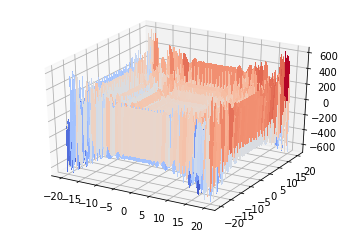

In [15]:
fig = plt.figure()
ax = fig.gca(projection='3d')

ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, linewidth=0, antialiased=False)

<i> 1.2 Сравните эти методы на функции $J(x, y) = x^2+y^2$</i>

GD tensor([6.8874e-38], dtype=torch.float64, grad_fn=<AddBackward0>)
Momenum tensor([1.8757e-44], dtype=torch.float64, grad_fn=<AddBackward0>)
NAG tensor([6.4541e-43], dtype=torch.float64, grad_fn=<AddBackward0>)
RMSProp tensor([0.0037], dtype=torch.float64, grad_fn=<AddBackward0>)
Adadelta tensor([3.1151e-75], dtype=torch.float64, grad_fn=<AddBackward0>)
Adam tensor([1.6478e-07], dtype=torch.float64, grad_fn=<AddBackward0>)


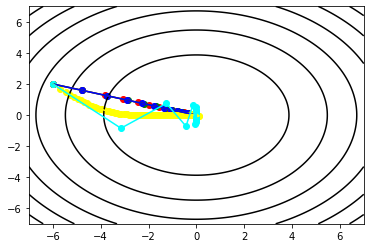

In [5]:
def J(X,Y):
    return X**2+Y**2

test(J,0.1,7)


<i>1.3 Сравните эти методы на функции $J(x, y) = x^2sin(x)+y^2sin(y)$</i>

GD tensor([-3.9453], dtype=torch.float64, grad_fn=<AddBackward0>)
Momenum tensor([-3.9453], dtype=torch.float64, grad_fn=<AddBackward0>)
NAG tensor([6.2549e-06], dtype=torch.float64, grad_fn=<AddBackward0>)
RMSProp tensor([-63.5467], dtype=torch.float64, grad_fn=<AddBackward0>)
Adadelta tensor([-3.9453], dtype=torch.float64, grad_fn=<AddBackward0>)
Adam tensor([-67.5803], dtype=torch.float64, grad_fn=<AddBackward0>)


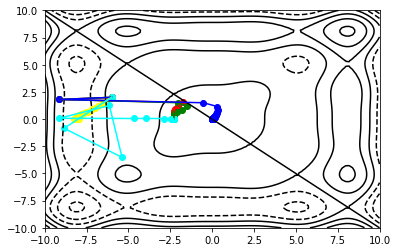

In [6]:
def J(x, y):
  if isinstance(x, np.ndarray):
    return x**2 * np.sin(x) + y**2 * np.sin(y)
  else:
    return x**2 * x.sin() + y**2 * y.sin()

test(J)

<i>1.3 Сравните эти методы на функции $J(x,y)=x^2sin(x^2)+y^2sin(y^2)$</i>

GD tensor([-40.8725], dtype=torch.float64, grad_fn=<AddBackward0>)
Momenum tensor([-40.9016], dtype=torch.float64, grad_fn=<AddBackward0>)
NAG tensor([-40.9014], dtype=torch.float64, grad_fn=<AddBackward0>)
RMSProp tensor([-39.4459], dtype=torch.float64, grad_fn=<AddBackward0>)
Adadelta tensor([-124.4197], dtype=torch.float64, grad_fn=<AddBackward0>)
Adam tensor([-39.5174], dtype=torch.float64, grad_fn=<AddBackward0>)


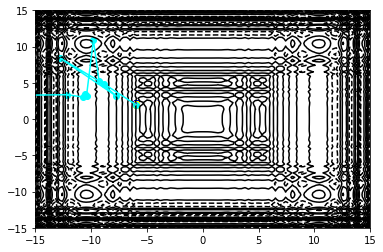

In [7]:
def J(x, y):
  if isinstance(x, np.ndarray):
    return x**2 * np.sin(x**2) + y**2 * np.sin(y**2)
  else:
    return x**2 * ((x**2).sin()) + y**2 * ((y**2).sin())

test(J,0.0001,15)

###  Часть 2: Обучение нейронной сети

<i> 2.1 Сравните графики обучения для полносвязной нейросети на методах Adam, Adagrad, AdaDelta и SGD (на MNIST). </i>

In [8]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


/pytorch/torch/csrc/utils/tensor_numpy.cpp:141: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program.


In [0]:

optimizers = [
    GD,
    RMSProp,
    Adadelta,
    Adam
]

names=[
        'GD',
        'RMSProp',
        'Adadelta',
        'Adam'
]

losses=[[] for i in range(len(names))]

for optim,loss in zip(optimizers,losses):
    net=nn.Sequential(
        nn.Linear(28*28,1024),
        nn.ReLU(),
        nn.Linear(1024,10),
        nn.LogSoftmax(dim=-1)
    )
    optim=optim(net.parameters(),0.01)
    for x,y in train_loader:
        y_pred=net.forward(x.view(x.size(0),-1))
        def err(f=nn.NLLLoss(),y_pred=y_pred,y=y):
            return f(y_pred,y)
        optim.step(err)
        with torch.no_grad():
            loss.append(err().item())


GD


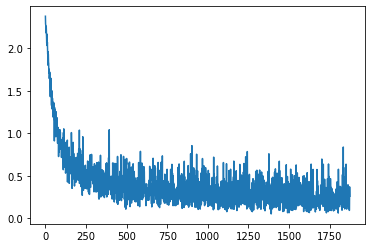

In [42]:
i=0
l=losses[i]
print(names[i])
plt.plot(list(range(len(l))),l)

RMSProp


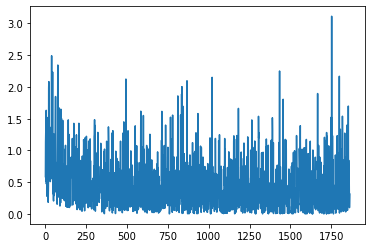

In [47]:
i=1
l=losses[i][10:]
print(names[i])
plt.plot(list(range(len(l))),l)

Adadelta


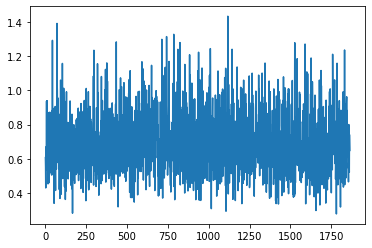

In [48]:
i=2
l=losses[i][10:]
print(names[i])
plt.plot(list(range(len(l))),l)

Adam


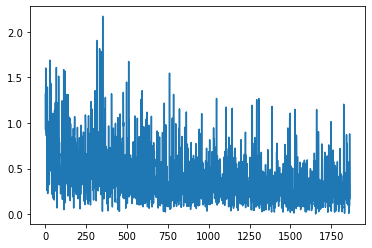

In [49]:
i=3
l=losses[i][10:]
print(names[i])
plt.plot(list(range(len(l))),l)

***Я вывел все ошибки начиная с 10 итерации (везде кроме SGD), так как изначальная ошибка очень большая и это мешает визаулизации<br>
Видно, что все улучшенные методы за 10 итераций успели сойтись довольно хорошо (SGD в это время имеет довольно большую ошибку), однако далее Adadelta и RMSProp начинают скакать. Явный спускающийся тренд заметен лишь в Adam.***

<i> 2.2 Сравните графики обучения для сверточной нейросети на методах Adam, Adagrad, AdaDelta и SGD. </i>

In [0]:
optimizers = [
    GD,
    RMSProp,
    Adadelta,
    Adam
]

names=[
        'GD',
        'RMSProp',
        'Adadelta',
        'Adam'
]

losses=[[] for i in range(len(names))]

class Flatten(nn.Module):
    def forward(self,x):
        return x.view(x.size(0),-1)

for optim,loss in zip(optimizers,losses):
    net=nn.Sequential(
        nn.Conv2d(1,32,3,padding=1),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.Conv2d(32,64,3,padding=1),
        nn.MaxPool2d(2),
        nn.BatchNorm2d(64),
        nn.ReLU(),
        Flatten(),
        nn.Linear(7*7*64,100),
        nn.Linear(100,10),
        nn.LogSoftmax(dim=-1)
    )
    optim=optim(net.parameters(),0.01)
    for x,y in train_loader:
        y_pred=net.forward(x)
        def err(f=nn.NLLLoss(),y_pred=y_pred,y=y):
            return f(y_pred,y)
        optim.step(err)
        with torch.no_grad():
            loss.append(err().item())

GD


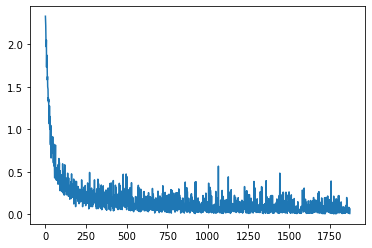

In [64]:
i=0
l=losses[i]
print(names[i])
plt.plot(list(range(len(l))),l)

RMSProp


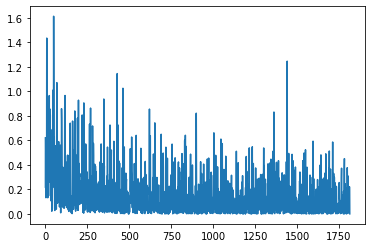

In [69]:
i=1
l=losses[i][60:]
print(names[i])
plt.plot(list(range(len(l))),l)

Adadelta


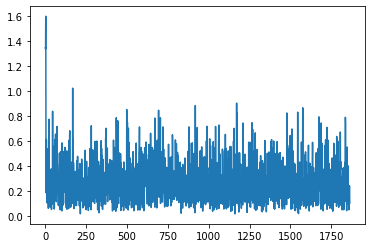

In [57]:
i=2
l=losses[i][10:]
print(names[i])
plt.plot(list(range(len(l))),l)

Adam


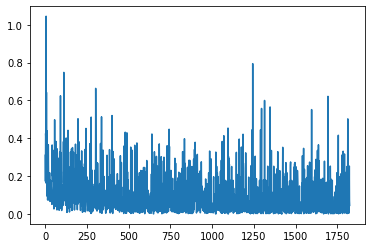

In [67]:
i=3
l=losses[i][50:]
print(names[i])
plt.plot(list(range(len(l))),l)

***Adadelta невероятно быстро сошлась до loss=0.4, затем сошёлся Adam до loss=0.2 (но сильно скачет) и RMSProp сошёлся до loss=0.2 лишь к концу эпохи (но он скачет не особо сильно и заметен явный нисходящий тренд)***<br>

***Суммарно все оптимизаторы показали себя хорошо. В данном небольшом состязании я бы расставил места следующим образом:<br>
1) Adam<br>
2) Adadelta<br>
3) RMSProp<br>***

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: